In [2]:
import essentia
import numpy as np
import matplotlib.pyplot as plt
import utils
from essentia.standard import MonoLoader, TensorflowPredictMusiCNN, TensorflowPredict2D


2025-08-31 15:48:40.458676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-31 15:48:40.458723: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[   INFO   ] MusicExtractorSVM: no classifier models were configured by default
2025-08-31 15:48:41.382249: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-31 15:48:41.385052: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-08-31 15:48:4

In [20]:
AUDIO = 'audio/testSong.mp3'

audio = MonoLoader(filename=AUDIO, sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictMusiCNN(graphFilename="models/msd-musicnn-1.pb", output="model/dense/BiasAdd")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="models/deam-msd-musicnn-2.pb", output="model/Identity")

# predictions.shape
# windowLength = 3 sec, hopLength = 1.5 seconds
predictions = model(embeddings)


2025-08-31 15:54:49.765704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-31 15:54:49.765771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4060 Laptop GPU computeCapability: 8.9
coreClock: 2.01GHz coreCount: 24 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 238.45GiB/s
2025-08-31 15:54:49.765787: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1766] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-08-31 15:54:49.765798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:125

In [19]:
def normalize(values):
    # arousal and valences are ranged from [1,9]
    # normalize to [-1,1]
    return 2 * ((values - 1) / 8) - 1

In [22]:
predictionsN = normalize(predictions)
utils.saveAsJson('va', predictionsN.tolist())


In [32]:
timeStamps = np.linspace(0, utils.getDurtion(audioFile=AUDIO), num=len(predictionsN), endpoint=False)
utils.saveAsJson('timeStamps', timeStamps.tolist())

In [34]:
len(audio)

3178561

In [7]:
def plotVA(predictions, duration=45.0):
    valence = predictions[:, 0]
    arousal = predictions[:, 1]

    n = len(predictions)
    hop = duration / n
    time = np.arange(n) * hop + hop / 2.0

    plt.figure(figsize=(9,4))
    plt.plot(time, valence, label="Valence")
    plt.plot(time, arousal, label="Arousal")
    plt.xlabel('Time(s)')
    plt.ylabel('score')
    plt.title('V/A over time')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return 

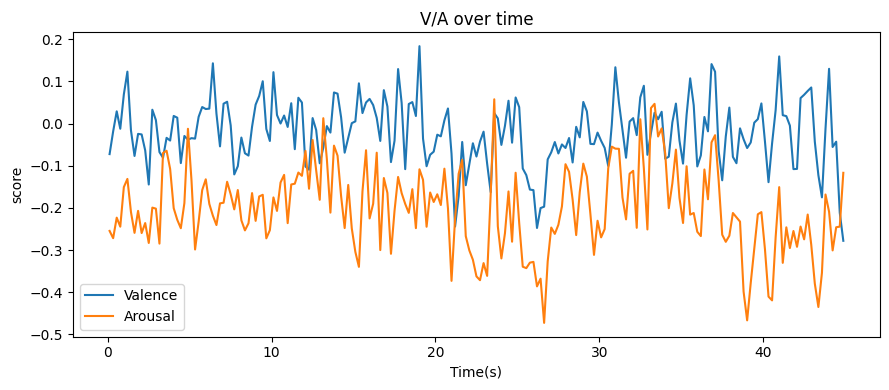

In [ ]:
plotVA(predictions=predictions)

In [8]:
from matplotlib.animation import FuncAnimation, PillowWriter

def animateVA(predictions):
    valence = predictions[:, 0]
    arousal = predictions[:, 1]
    n = len(predictions)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlabel("Valence", loc='right', labelpad=15)
    ax.set_ylabel("Arousal", loc='top', labelpad=15)
    ax.set_title("VA on 2D plane")

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    dot, = ax.plot([],[], marker='o', markersize=8, linestyle="")

    def init():
        dot.set_data([],[])
        return dot,

    def update(frame):
        # X means the animation is ending
        if frame >= n-5:
            dot.set_marker('X')
        dot.set_data([valence[frame]], [arousal[frame]])
        return dot,
    
    animation = FuncAnimation(fig, update, frames=n, init_func=init, blit=True)
    animation.save('VA_on_2d_plane.gif', writer=PillowWriter(fps=8))
    plt.show()
    plt.close()



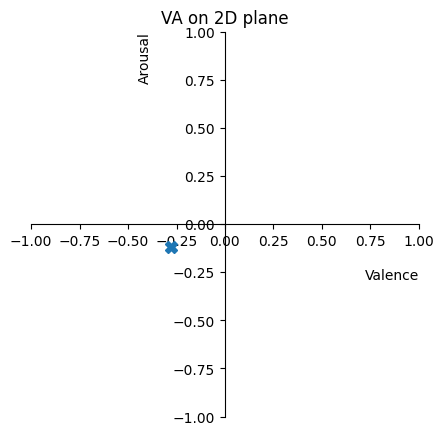

In [ ]:
animateVA(predictions=predictions)

In [9]:
def polarCoordinate(predictions):
    valence = predictions[:, 0]
    arousal = predictions[:, 1]

    res = []
    r = np.sqrt(valence**2 + arousal**2)
    theta = np.arctan2(valence, arousal) * 180 / np.pi
    theta = np.where(theta < 0, theta + 360, theta)

    return zip(r, theta)

In [10]:
coordinates = np.array(list(polarCoordinate(predictions=predictions)))

In [ ]:
def hard_classify(theta):
    if 0 <= theta < 22.5:
        return "happy"
    elif 22.5 <= theta < 45:
        return "elated"
    elif 45 <= theta < 67.5:
        return "excited"
    elif 67.5 <= theta < 90:
        return "alert"
    elif 90 <= theta < 112.5:
        return "tense"
    elif 112.5 <= theta < 135:
        return "nervous"
    elif 135 <= theta < 157.5:
        return "stressed"
    elif 157.5 <= theta < 180:
        return "upset"
    elif 180 <= theta < 202.5:
        return "sad"
    elif 202.5 <= theta < 225:
        return "depressed"
    elif 225 <= theta < 247.5:
        return "lethargic"
    elif 247.5 <= theta < 270:
        return "fatigued"
    elif 270 <= theta < 292.5:
        return "calm"
    elif 292.5 <= theta < 315:
        return "relaxed"
    elif 315 <= theta < 337.5:
        return "serene"
    else:
        return "contented"

hardClassifyMatrix = np.vectorize(hard_classify)

In [11]:
emotionCennters = {
    "happy": [0.9, 0.1],
    "surprise": [0.3, 0.9],
    "sad": [-0.8, -0.5],
    "angry": [-0.1, 0.8],
    "fear": [-0.3, 0.8],
    "disgust": [-0.4, 0.6],
}

def soft_classify(point, sigma=0.3):
    #Uses Radial Basis Function Kernel

    weights = {}

    for emotion, center in emotionCennters.items():
        dist = np.linalg.norm(point - center)
        weights[emotion] = np.exp(-dist**2 / (2 * sigma**2))

    #normalize
    total = sum(weights.values())
    for k in weights:
        weights[k] /= total
        
    return weights



In [12]:
hlabels = hardClassifyMatrix(coordinates[:, 1])
hlabels


NameError: name 'hardClassifyMatrix' is not defined

In [13]:
slabels = [soft_classify(point) for point in predictions]
slabels
utils.saveAsJson('soft_label', slabels)

In [14]:
res = []
for label in slabels:
    max_key = max(label, key=label.get)
    print(max_key)

    

sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad
sad


In [ ]:
duration = utils.getDurtion(AUDIO)
duration

310.2936875

In [ ]:
def plotEmotion(emotions, duration):
    
    return
